## 0. 환경설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 시각화 관련
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from PIL import Image
from matplotlib import rc

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

## 1. 안전성

### 1-1. data 전처리

In [2]:
d1 = pd.read_csv('data/교통사고+현황(구별)_20221021121851.csv', encoding='cp949')
d1 = d1['시점\t자치구별(2)\t발생건수 (건)\t자동차 1만대당 발생건수 (건)\t사망자수 (명)\t인구 10만명당 사망자수 (명)\t부상자수 (명)\t인구 10만명당 부상자수 (명)'].str.split('\t',expand = True)
d1.columns = ['year','Gu','num','car10000_num','dead','dead_per100000','injured','injured_per100000']
d1 = d1.astype({'num':'float'})
d1 = d1.astype({'car10000_num':'float'})
d1 = d1.astype({'dead':'float'})
d1 = d1.astype({'dead_per100000':'float'})
d1 = d1.astype({'injured':'float'})
d1 = d1.astype({'injured_per100000':'float'})
d1.head()

,year,Gu,num,car10000_num,dead,dead_per100000,injured,injured_per100000
0,2021,종로구,778.0,122.6,6.0,3.9,1050.0,682.8
1,2021,중구,854.0,113.3,3.0,2.3,1156.0,877.2
2,2021,용산구,1014.0,105.1,5.0,2.1,1369.0,576.9
3,2021,성동구,1057.0,84.6,8.0,2.7,1362.0,465.4
4,2021,광진구,922.0,78.7,4.0,1.1,1216.0,344.8


In [3]:
#100에 가까울수록 안전
d2 = pd.read_csv('data/교통안전지수_20221021121453.csv')# encoding='cp949')
d2.columns = ['서울시','Gu','2020교통안전지수']
d2 = d2.drop(0, axis=0) #소계 행 삭제
d2.head()

,서울시,Gu,2020교통안전지수
1,서울시,종로구,79.78
2,서울시,중구,75.20
3,서울시,용산구,79.97
4,서울시,성동구,78.71
5,서울시,광진구,83.00


In [4]:
#교통안전지수 제외 모두 2021data
df_safety = pd.merge(d1,d2)
df_safety = df_safety.drop(['서울시','year'],axis = 1)
df_safety.head()
#최종데이터: df_safety 

,Gu,num,car10000_num,dead,dead_per100000,injured,injured_per100000,2020교통안전지수
0,종로구,778.0,122.6,6.0,3.9,1050.0,682.8,79.78
1,중구,854.0,113.3,3.0,2.3,1156.0,877.2,75.20
2,용산구,1014.0,105.1,5.0,2.1,1369.0,576.9,79.97
3,성동구,1057.0,84.6,8.0,2.7,1362.0,465.4,78.71
4,광진구,922.0,78.7,4.0,1.1,1216.0,344.8,83.00


### 1-2. 안전성_탐색적 요인 분석

In [5]:
from sklearn.preprocessing import MinMaxScaler
df_safety_test = df_safety.drop(['Gu'],axis = 1)
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(df_safety_test)
df_safety_test_s = min_max_scaler.transform(df_safety_test)
df_safety_test_s = pd.DataFrame(df_safety_test_s, columns=(df_safety_test).columns, index=list(df_safety_test.index.values))
df_safety_test_s.head()

,num,car10000_num,dead,dead_per100000,injured,injured_per100000,2020교통안전지수
0,0.057913,0.721053,0.214286,0.535714,0.063989,0.612774,0.791990
1,0.081449,0.623158,0.000000,0.250000,0.088042,0.882100,0.496124
2,0.131000,0.536842,0.142857,0.214286,0.136374,0.466057,0.804264
3,0.144317,0.321053,0.357143,0.321429,0.134786,0.311582,0.722868
4,0.102509,0.258947,0.071429,0.035714,0.101656,0.144500,1.000000


In [6]:
df_safety_test_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num                25 non-null     float64
 1   car10000_num       25 non-null     float64
 2   dead               25 non-null     float64
 3   dead_per100000     25 non-null     float64
 4   injured            25 non-null     float64
 5   injured_per100000  25 non-null     float64
 6   2020교통안전지수         25 non-null     float64
dtypes: float64(7)
memory usage: 1.6 KB


In [7]:
# Bartlett test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_safety_test_s)
chi_square_value, p_value 

(242.4796803837351, 1.3231646965854372e-39)

In [8]:
#KMO검정
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model = calculate_kmo(df_safety_test_s)
kmo_model

0.5605211481735087

In [9]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors = 10, rotation = None)
fa.fit(df_safety_test_s)
ev,v = fa.get_eigenvalues()
ev

array([3.89271187e+00, 1.66759417e+00, 1.05035620e+00, 2.55061000e-01,
       9.53477725e-02, 3.75117670e-02, 1.41721079e-03])

* y축의 값이 1이상이면서 1에 가장 가까운 값이 가장 적합!->3

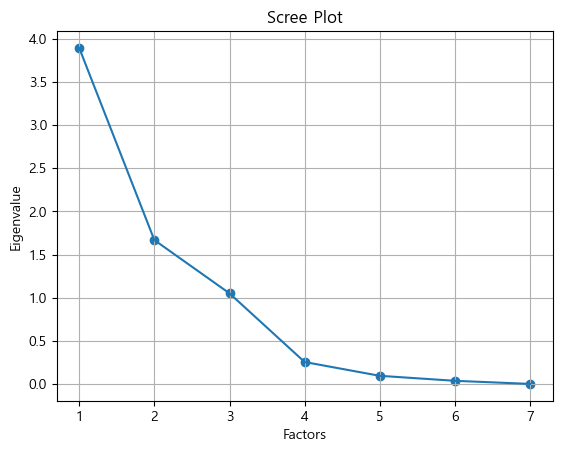

In [10]:
plt.scatter(range(1,df_safety_test_s.shape[1]+1),ev)
plt.plot(range(1,df_safety_test_s.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [11]:
fa = FactorAnalyzer(n_factors=3,rotation = "varimax")
fa.fit(df_safety_test_s)
efa_result = pd.DataFrame(fa.loadings_,index = df_safety_test_s.columns)
efa_result

,0,1,2
num,0.955174,0.286490,0.043507
car10000_num,0.361798,0.781961,0.057999
dead,0.338670,-0.204789,0.873152
dead_per100000,-0.251472,0.245557,0.934067
injured,0.952744,0.290683,0.034118
injured_per100000,0.343664,0.940548,-0.012639
2020교통안전지수,-0.768976,-0.391662,0.003761


<AxesSubplot: >

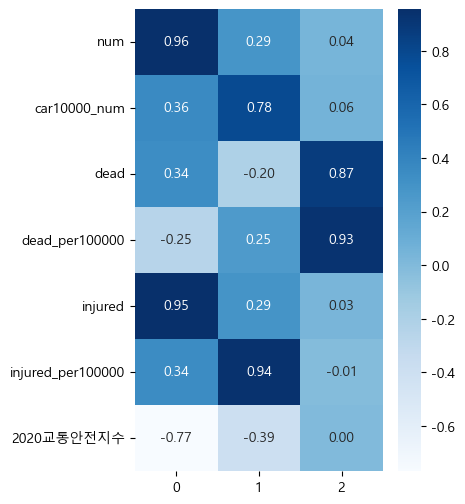

In [12]:
plt.figure(figsize = (4,6))
sns.heatmap(efa_result,cmap = "Blues",annot = True, fmt = '.2f')

In [13]:
efa_result['mean'] = (efa_result[0] +efa_result[1] +efa_result[2])/3
efa_result

,0,1,2,mean
num,0.955174,0.286490,0.043507,0.428390
car10000_num,0.361798,0.781961,0.057999,0.400586
dead,0.338670,-0.204789,0.873152,0.335678
dead_per100000,-0.251472,0.245557,0.934067,0.309384
injured,0.952744,0.290683,0.034118,0.425848
injured_per100000,0.343664,0.940548,-0.012639,0.423858
2020교통안전지수,-0.768976,-0.391662,0.003761,-0.385626


In [15]:
print('가중치_안전성')
print('1위 발생건수_num:',round(0.428390/(0.428390+0.400586+0.335678+0.309384+0.425848+0.423858),2))
print('2위 부상자수_injured:',round(0.425848/(0.428390+0.400586+0.335678+0.309384+0.425848+0.423858),2))
print('3위 10만명당 부상자수_injured_per100000:',round(0.423858/(0.428390+0.400586+0.335678+0.309384+0.425848+0.423858),2))
print('4위 차 1만대당 발생건수_car10000_num:',round(0.400586/(0.428390+0.400586+0.335678+0.309384+0.425848+0.423858),2))
print('5위 사망자_dead:',round(0.335678/(0.428390+0.400586+0.335678+0.309384+0.425848+0.423858),2))
print('6위 10만명당 사망자수_dead_per100000:',round(0.309384/(0.428390+0.400586+0.335678+0.309384+0.425848+0.423858),2))



가중치_안전성
1위 발생건수_num: 0.18
2위 부상자수_injured: 0.18
3위 10만명당 부상자수_injured_per100000: 0.18
4위 차 1만대당 발생건수_car10000_num: 0.17
5위 사망자_dead: 0.14
6위 10만명당 사망자수_dead_per100000: 0.13


### 1-3. 안전성_최종지표_구_동

* 가중치_안전성
  * 1위 발생건수_num: 0.18
  * 2위 부상자수_injured: 0.18
  * 3위 10만명당 부상자수_injured_per100000: 0.18
  * 4위 차 1만대당 발생건수_car10000_num: 0.17
  * 5위 사망자_dead: 0.14
  * 6위 10만명당 사망자수_dead_per100000: 0.13

In [48]:
safety_final = pd.concat([df_safety['Gu'], df_safety_test_s],axis = 1)
safety_final['불안전성지표'] = (safety_final['num']*0.18 + safety_final['injured']*0.18 
                             + safety_final['injured_per100000']*0.18 + safety_final['car10000_num']*0.17
                             +safety_final['dead']*0.14 + safety_final['dead_per100000']*0.13)
safety_final= safety_final.sort_values(by = ['불안전성지표'],ascending = False)
safety_final.rename(columns = {'Gu':'자치구명'},inplace=True)
safety_final.head()


,자치구명,num,car10000_num,dead,dead_per100000,injured,injured_per100000,2020교통안전지수,불안전성지표
22,강남구,1.000000,1.000000,0.500000,0.178571,1.000000,1.000000,0.000000,0.803214
18,영등포구,0.491483,0.822105,0.857143,0.500000,0.498979,0.692158,0.497416,0.627630
23,송파구,0.624342,0.457895,0.785714,0.214286,0.621965,0.399002,0.394057,0.511855
5,동대문구,0.247445,0.624211,1.000000,0.696429,0.201498,0.318509,0.616925,0.474793
21,서초구,0.472902,0.611579,0.357143,0.178571,0.491037,0.642837,0.618863,0.466402


In [20]:
df_dong = pd.read_csv('data/행정구역전처리.csv')
df_dong.head()

,Unnamed: 0,자치구명,행정구역명,행정동,법정동,행정구역분류
0,2,종로구,청운효자동,청운효자동,청운동,1101072
1,3,종로구,청운효자동,청운효자동,신교동,1101072
2,4,종로구,청운효자동,청운효자동,궁정동,1101072
3,5,종로구,청운효자동,청운효자동,효자동,1101072
4,6,종로구,청운효자동,청운효자동,창성동,1101072


In [77]:
safety_dong = pd.merge(df_dong,safety_final)
safety_dong = safety_dong.drop(['Unnamed: 0','법정동','행정구역분류',
                                'num','car10000_num','dead','dead_per100000',
                                'injured','injured_per100000','2020교통안전지수','행정구역명'],axis=1)
safety_dong= safety_dong.sort_values(by = ['불안전성지표'],ascending = False)
print(safety_dong.head())
print(safety_dong.shape)
safety_dong= safety_dong.drop_duplicates()
print(safety_dong.head())
print(safety_dong.shape)

    자치구명   행정동    불안전성지표
662  강남구   신사동  0.803214
669  강남구  삼성2동  0.803214
676  강남구  도곡2동  0.803214
675  강남구  도곡1동  0.803214
674  강남구  역삼2동  0.803214
(741, 3)
    자치구명   행정동    불안전성지표
662  강남구   신사동  0.803214
669  강남구  삼성2동  0.803214
676  강남구  도곡2동  0.803214
675  강남구  도곡1동  0.803214
674  강남구  역삼2동  0.803214
(426, 3)


In [59]:
print(safety_dong['행정동'].nunique())
print(safety_dong['불안전성지표'].nunique())
print(safety_dong['자치구명'].nunique())

425
25
25


In [60]:
safety_dong.to_csv('[221025]safety_dong.csv')

## 2. 상업지역

### 2-1. 데이터 전처리

In [2]:
d1 = pd.read_csv('data/B058. 서울시 행정동단위 분기별 추정매출액/2. 파일데이터/2018/TBDM_BLCK_SELNG_QU_2018_4분기.txt',delimiter = '|')
d2 = pd.read_csv('data/B058. 서울시 행정동단위 분기별 추정매출액/2. 파일데이터/2019/TBDM_BLCK_SELNG_QU_2019_1분기.txt',delimiter = '|')  
d3 = pd.read_csv('data/B058. 서울시 행정동단위 분기별 추정매출액/2. 파일데이터/2019/TBDM_BLCK_SELNG_QU_2019_2분기.txt',delimiter = '|') 
d4 = pd.read_csv('data/B058. 서울시 행정동단위 분기별 추정매출액/2. 파일데이터/2019/TBDM_BLCK_SELNG_QU_2019_3분기.txt',delimiter = '|') 

In [3]:
d5 = pd.read_csv('data/서울시 우리마을가게 상권분석서비스(행정동별 상권변화지표).csv',encoding='cp949')
d5.rename(columns = {'행정동_코드_명':'ADSTRD_NM'},inplace=True)
d5=d5.pivot_table(values = ['운영_영업_개월_평균','폐업_영업_개월_평균','서울_운영_영업_개월_평균','서울_폐업_영업_개월_평균'],index = ['ADSTRD_NM'],aggfunc="mean")
d5 = d5.reset_index()
d5.head()
#2021 data

,ADSTRD_NM,서울_운영_영업_개월_평균,서울_폐업_영업_개월_평균,운영_영업_개월_평균,폐업_영업_개월_평균
0,가락1동,116.5,54.75,178.00,151.00
1,가락2동,116.5,54.75,118.75,52.00
2,가락본동,116.5,54.75,114.25,49.00
3,가리봉동,116.5,54.75,126.75,53.50
4,가산동,116.5,54.75,98.00,49.25


In [4]:
df_commercial = pd.concat([d1,d2,d3,d4], axis = 0) 
df_commercial=df_commercial.pivot_table(values = ['SUM_SELNG_AMT','SUM_SELNG_CO'],index = ['ADSTRD_NM'],aggfunc="sum")
df_commercial = df_commercial.reset_index()
df_commercial.head()
#최종 데이터 df_commercial

,ADSTRD_NM,SUM_SELNG_AMT,SUM_SELNG_CO
0,가락1동,250239049096,6632777
1,가락2동,233581351355,10922847
2,가락본동,295067067226,15633802
3,가리봉동,80613761036,5472862
4,가산동,779453179401,44222847


In [5]:
#행정동기준으로 merge, concat
df_commercial = pd.merge(df_commercial,d5)
df_commercial = df_commercial.drop(['서울_운영_영업_개월_평균','서울_폐업_영업_개월_평균'],axis=1)
df_commercial .head()

,ADSTRD_NM,SUM_SELNG_AMT,SUM_SELNG_CO,운영_영업_개월_평균,폐업_영업_개월_평균
0,가락1동,250239049096,6632777,178.00,151.00
1,가락2동,233581351355,10922847,118.75,52.00
2,가락본동,295067067226,15633802,114.25,49.00
3,가리봉동,80613761036,5472862,126.75,53.50
4,가산동,779453179401,44222847,98.00,49.25


### 2-2. 상업지역_탐색적요인분석

In [34]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(df_commercial.drop(['ADSTRD_NM'],axis = 1))
df_commercial_s = min_max_scaler.transform(df_commercial.drop(['ADSTRD_NM'],axis = 1))
df_commercial_s = pd.DataFrame(df_commercial_s, columns=(df_commercial.drop(['ADSTRD_NM'],axis = 1)).columns, index=list(df_commercial.drop(['ADSTRD_NM'],axis = 1).index.values))
df_commercial_s.head()

,SUM_SELNG_AMT,SUM_SELNG_CO,운영_영업_개월_평균,폐업_영업_개월_평균
0,0.135054,0.065196,1.000000,1.000000
1,0.125953,0.108255,0.574506,0.200000
2,0.159545,0.155539,0.542190,0.175758
3,0.042382,0.053554,0.631957,0.212121
4,0.424181,0.442487,0.425494,0.177778


In [35]:
# Bartlett test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_commercial_s)
chi_square_value, p_value 

(1172.438079729501, 4.4144573079029833e-250)

In [36]:
#KMO검정
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model = calculate_kmo(df_commercial_s)
kmo_model

0.5009854666045733

In [37]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors = 10, rotation = None)
fa.fit(df_commercial_s)
ev,v = fa.get_eigenvalues()
ev

array([1.9730719 , 1.63551001, 0.33469938, 0.0567187 ])

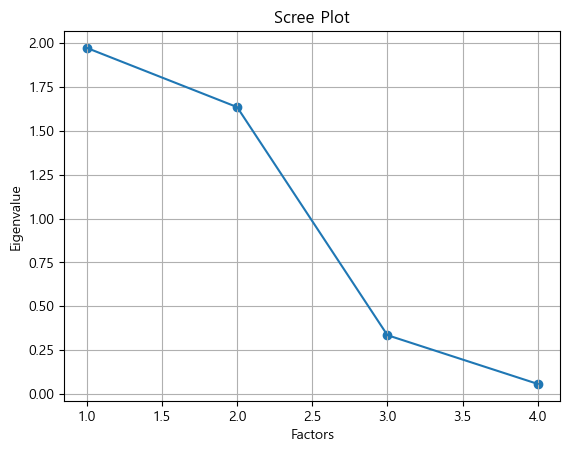

In [38]:
plt.scatter(range(1,df_commercial_s.shape[1]+1),ev)
plt.plot(range(1,df_commercial_s.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
#2

In [39]:
fa = FactorAnalyzer(n_factors=2,rotation = "varimax")
fa.fit(df_commercial_s)
efa_result = pd.DataFrame(fa.loadings_,index = df_commercial_s .columns)
efa_result

,0,1
SUM_SELNG_AMT,0.997306,0.009675
SUM_SELNG_CO,0.944746,-0.041459
운영_영업_개월_평균,0.009848,0.837641
폐업_영업_개월_평균,-0.076858,0.790903


<AxesSubplot: >

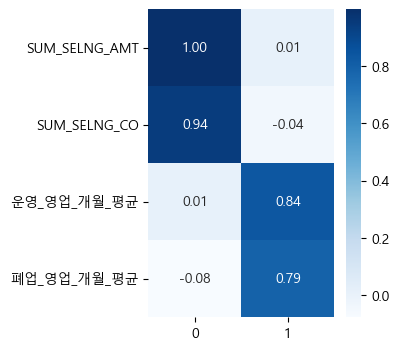

In [40]:
plt.figure(figsize = (3,4))
sns.heatmap(efa_result,cmap = "Blues",annot = True, fmt = '.2f')

In [41]:
efa_result['mean'] = (efa_result[0] +efa_result[1])/2
efa_result

,0,1,mean
SUM_SELNG_AMT,0.997306,0.009675,0.503491
SUM_SELNG_CO,0.944746,-0.041459,0.451643
운영_영업_개월_평균,0.009848,0.837641,0.423744
폐업_영업_개월_평균,-0.076858,0.790903,0.357022


In [42]:
print('가중치_안전성')
print('1위 SUM_SELNG_AMT:',round(0.503491/(0.503491+0.451643+0.423744+0.357022),2))
print('2위 SUM_SELNG_CO:',round(0.451643/(0.503491+0.451643+0.423744+0.357022),2))
print('3위 운영_영업_개월_평균:',round(0.423744/(0.503491+0.451643+0.423744+0.357022),2))
print('4위 폐업_영업_개월_평균:',round(0.357022/(0.503491+0.451643+0.423744+0.357022),2))

가중치_안전성
1위 SUM_SELNG_AMT: 0.29
2위 SUM_SELNG_CO: 0.26
3위 운영_영업_개월_평균: 0.24
4위 폐업_영업_개월_평균: 0.21


### 2-3.상업지역_최종지표_구_동

* 가중치_상업지역
  * 1위 SUM_SELNG_AMT: 0.29
  * 2위 SUM_SELNG_CO: 0.26
  * 3위 운영_영업_개월_평균: 0.24
  * 4위 폐업_영업_개월_평균: 0.21

In [70]:
commercial_final = pd.concat([df_commercial['ADSTRD_NM'],df_commercial_s],axis = 1)
commercial_final['상업지표'] = (commercial_final['SUM_SELNG_AMT']*0.29 + commercial_final['SUM_SELNG_CO']*0.26 
                             + commercial_final['운영_영업_개월_평균']*0.24 + commercial_final['폐업_영업_개월_평균']*0.21)
commercial_final= commercial_final.sort_values(by = ['상업지표'],ascending = False)
commercial_final.rename(columns = {'ADSTRD_NM':'행정구역명'},inplace=True)
print(commercial_final.head())
print(commercial_final['행정구역명'].nunique())

           행정구역명  SUM_SELNG_AMT  SUM_SELNG_CO  운영_영업_개월_평균  폐업_영업_개월_평균  \
277         역삼1동       1.000000      1.000000     0.477558     0.167677   
352  종로1.2.3.4가동       0.629086      0.573802     0.804309     0.339394   
187          서교동       0.846377      0.830552     0.377020     0.169697   
108           명동       0.498397      0.527745     0.836625     0.254545   
0           가락1동       0.135054      0.065196     1.000000     1.000000   

         상업지표  
277  0.699826  
352  0.595930  
187  0.587514  
108  0.535993  
0    0.506117  
423


In [46]:
df_dong = pd.read_csv('data/행정구역전처리.csv')
df_dong.head()

,Unnamed: 0,자치구명,행정구역명,행정동,법정동,행정구역분류
0,2,종로구,청운효자동,청운효자동,청운동,1101072
1,3,종로구,청운효자동,청운효자동,신교동,1101072
2,4,종로구,청운효자동,청운효자동,궁정동,1101072
3,5,종로구,청운효자동,청운효자동,효자동,1101072
4,6,종로구,청운효자동,청운효자동,창성동,1101072


In [67]:
print(df_dong['행정동'].nunique())
print(df_dong['행정구역명'].nunique())

425
425


In [76]:
commercial_dong = pd.merge(df_dong,commercial_final)
commercial_dong = commercial_dong.drop(['Unnamed: 0','법정동','행정구역분류',
                                'SUM_SELNG_AMT','SUM_SELNG_CO','운영_영업_개월_평균',
                                '폐업_영업_개월_평균','행정구역명'],axis=1)
commercial_dong= commercial_dong.sort_values(by = ['상업지표'],ascending = False)

print(commercial_dong.head())
print(commercial_dong.shape)
commercial_dong= commercial_dong.drop_duplicates()
print(commercial_dong.head())
print(commercial_dong.shape)

    자치구명          행정동      상업지표
672  강남구         역삼1동  0.699826
61   종로구  종로1.2.3.4가동  0.595930
56   종로구  종로1.2.3.4가동  0.595930
46   종로구  종로1.2.3.4가동  0.595930
60   종로구  종로1.2.3.4가동  0.595930
(738, 3)
    자치구명          행정동      상업지표
672  강남구         역삼1동  0.699826
61   종로구  종로1.2.3.4가동  0.595930
464  마포구          서교동  0.587514
120   중구           명동  0.535993
706  송파구         가락1동  0.506117
(423, 3)


In [74]:
print(commercial_dong['자치구명'].nunique())
print(commercial_dong['행정동'].nunique())
print(commercial_dong['상업지표'].nunique())

25
422
422


In [75]:
commercial_dong.to_csv('[221025]commercial_dong.csv')

In [79]:
commercial_dong[(commercial_dong['자치구명'] == "강남구") & (commercial_dong['행정동'] == "신사동")]
#df[(df['country']=='한국') | (df['country']=='호주')]

,자치구명,행정동,상업지표
630,강남구,신사동,0.430837


In [80]:
commercial_dong[(commercial_dong['자치구명'] == "관악구") & (commercial_dong['행정동'] == "신사동")]

,자치구명,행정동,상업지표
629,관악구,신사동,0.430837


## 3. [221026]상업 전처리 파일 다시생성_신사동

In [6]:
d5 = pd.read_csv('data/서울시 우리마을가게 상권분석서비스(행정동별 상권변화지표).csv',encoding='cp949')
d5.rename(columns = {'행정동_코드':'행정기관코드'},inplace=True)
d5=d5.pivot_table(values = ['운영_영업_개월_평균','폐업_영업_개월_평균'],index = ['행정기관코드'],aggfunc="mean")
d5 = d5.reset_index()
#기관코드
df_dong_gu= pd.read_csv('data/행정구역_기관코드포함.csv')
d5 = pd.merge(df_dong_gu,d5)
d5.drop(['Unnamed: 0','행정구역명','행정구역분류','자치구행정동','법정동'],axis = 1,inplace = True)
d5.head()

,자치구명,행정동,행정기관코드,운영_영업_개월_평균,폐업_영업_개월_평균
0,종로구,청운효자동,11110515,106.0,61.25
1,종로구,청운효자동,11110515,106.0,61.25
2,종로구,청운효자동,11110515,106.0,61.25
3,종로구,청운효자동,11110515,106.0,61.25
4,종로구,청운효자동,11110515,106.0,61.25


In [118]:
print(d5['행정기관코드'].nunique())
print(d5['운영_영업_개월_평균'].nunique())
print(d5['폐업_영업_개월_평균'].nunique())

417
179
96


In [7]:
d1 = pd.read_csv('data/B058. 서울시 행정동단위 분기별 추정매출액/2. 파일데이터/2018/TBDM_BLCK_SELNG_QU_2018_4분기.txt',delimiter = '|')
d2 = pd.read_csv('data/B058. 서울시 행정동단위 분기별 추정매출액/2. 파일데이터/2019/TBDM_BLCK_SELNG_QU_2019_1분기.txt',delimiter = '|')  
d3 = pd.read_csv('data/B058. 서울시 행정동단위 분기별 추정매출액/2. 파일데이터/2019/TBDM_BLCK_SELNG_QU_2019_2분기.txt',delimiter = '|') 
d4 = pd.read_csv('data/B058. 서울시 행정동단위 분기별 추정매출액/2. 파일데이터/2019/TBDM_BLCK_SELNG_QU_2019_3분기.txt',delimiter = '|') 

In [8]:
df_commercial = pd.concat([d1,d2,d3,d4], axis = 0) 
df_commercial.rename(columns = {'ADSTRD_CD':'행정기관코드'},inplace=True)
df_commercial=df_commercial.pivot_table(values = ['SUM_SELNG_AMT','SUM_SELNG_CO'],index = ['행정기관코드'],aggfunc="sum")
df_commercial = df_commercial.reset_index()
df_commercial = pd.merge(df_dong_gu,df_commercial)
df_commercial.drop(['Unnamed: 0','행정구역명','행정구역분류','자치구행정동','법정동'],axis = 1,inplace = True)
df_commercial.head()

,자치구명,행정동,행정기관코드,SUM_SELNG_AMT,SUM_SELNG_CO
0,종로구,청운효자동,11110515,76717519157,4891664
1,종로구,청운효자동,11110515,76717519157,4891664
2,종로구,청운효자동,11110515,76717519157,4891664
3,종로구,청운효자동,11110515,76717519157,4891664
4,종로구,청운효자동,11110515,76717519157,4891664


In [117]:
print(df_commercial['행정기관코드'].nunique())
print(df_commercial['SUM_SELNG_AMT'].nunique())

417
417


In [9]:
df_commercial = pd.merge(df_commercial,d5)
df_commercial.drop(['행정기관코드'],axis = 1,inplace= True)
df_commercial.head()

,자치구명,행정동,SUM_SELNG_AMT,SUM_SELNG_CO,운영_영업_개월_평균,폐업_영업_개월_평균
0,종로구,청운효자동,76717519157,4891664,106.0,61.25
1,종로구,청운효자동,76717519157,4891664,106.0,61.25
2,종로구,청운효자동,76717519157,4891664,106.0,61.25
3,종로구,청운효자동,76717519157,4891664,106.0,61.25
4,종로구,청운효자동,76717519157,4891664,106.0,61.25


In [121]:
df_commercial.to_csv('상업.csv')

In [10]:
df_commercial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3710 entries, 0 to 3709
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   자치구명           3710 non-null   object 
 1   행정동            3710 non-null   object 
 2   SUM_SELNG_AMT  3710 non-null   int64  
 3   SUM_SELNG_CO   3710 non-null   int64  
 4   운영_영업_개월_평균    3710 non-null   float64
 5   폐업_영업_개월_평균    3710 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 202.9+ KB


In [11]:
df_commercial = df_commercial.drop_duplicates()
df_commercial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 3709
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   자치구명           417 non-null    object 
 1   행정동            417 non-null    object 
 2   SUM_SELNG_AMT  417 non-null    int64  
 3   SUM_SELNG_CO   417 non-null    int64  
 4   운영_영업_개월_평균    417 non-null    float64
 5   폐업_영업_개월_평균    417 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 22.8+ KB


In [12]:
df_commercial.to_csv('[221117]상업_원시지표.csv')

In [7]:
df_commercial=pd.read_csv('[221117]상업_원시지표.csv')
df_commercial.rename(columns = {'자치구명' : '자치구'}, inplace = True)
df_commercial.drop(['Unnamed: 0'],axis = 1,inplace = True)
df_commercial.head()

,자치구,행정동,SUM_SELNG_AMT,SUM_SELNG_CO,운영_영업_개월_평균,폐업_영업_개월_평균
0,종로구,청운효자동,76717519157,4891664,106.00,61.25
1,종로구,사직동,294186825721,18441604,130.75,61.25
2,종로구,삼청동,93482870462,4547785,102.50,57.00
3,종로구,부암동,35862202180,2678128,105.25,59.25
4,종로구,평창동,70961467717,3319554,123.25,60.50


In [8]:
df = pd.read_csv('[221029]Indicator_concat_ver1.csv')
df.drop(['Unnamed: 0'],axis = 1,inplace = True)
df.head()

,자치구,행정동,불안전성지표,접근성지표,비환경지표,상업지표,주거지표,문화지표
0,강남구,신사동,0.803214,0.190622,0.410824,0.385027,0.295505,0.122344
1,강남구,삼성2동,0.803214,0.172469,0.223742,0.254874,0.504201,0.103986
2,강남구,도곡2동,0.803214,0.157665,0.187969,0.246147,0.498438,0.021014
3,강남구,도곡1동,0.803214,0.160310,0.296284,0.238506,0.364411,0.011785
4,강남구,역삼2동,0.803214,0.130481,0.268705,0.263553,0.611094,0.038454


In [9]:
df_final =pd.merge(df_commercial,df)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 416
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   자치구            417 non-null    object 
 1   행정동            417 non-null    object 
 2   SUM_SELNG_AMT  417 non-null    int64  
 3   SUM_SELNG_CO   417 non-null    int64  
 4   운영_영업_개월_평균    417 non-null    float64
 5   폐업_영업_개월_평균    417 non-null    float64
 6   불안전성지표         417 non-null    float64
 7   접근성지표          417 non-null    float64
 8   비환경지표          417 non-null    float64
 9   상업지표           417 non-null    float64
 10  주거지표           417 non-null    float64
 11  문화지표           417 non-null    float64
dtypes: float64(8), int64(2), object(2)
memory usage: 42.4+ KB


In [10]:
df_final.head()

,자치구,행정동,SUM_SELNG_AMT,SUM_SELNG_CO,운영_영업_개월_평균,폐업_영업_개월_평균,불안전성지표,접근성지표,비환경지표,상업지표,주거지표,문화지표
0,종로구,청운효자동,76717519157,4891664,106.00,61.25,0.354463,0.100722,0.158494,0.202037,0.208008,0.128717
1,종로구,사직동,294186825721,18441604,130.75,61.25,0.354463,0.344329,0.319950,0.314926,0.181815,0.130618
2,종로구,삼청동,93482870462,4547785,102.50,57.00,0.354463,0.078244,0.156656,0.190334,0.045034,0.075384
3,종로구,부암동,35862202180,2678128,105.25,59.25,0.354463,0.124857,0.169565,0.185269,0.162146,0.145680
4,종로구,평창동,70961467717,3319554,123.25,60.50,0.354463,0.152640,0.120060,0.226877,0.285614,0.161079
